## ⚖️ Choose A or B:

## A: Emulating multi-device system on CPU

Use this section to initialize a set of virtual devices on CPU if you have no access to a multi-device system.

It can also help you prototype, debug and test your multi-device code locally before running it on the expensive system.

Even in the case of using Google Colab it can help you prototype faster because a CPU runtime is faster to restart.

In [1]:
import os
os.environ['XLA_FLAGS'] = '--xla_force_host_platform_device_count=8'

In [2]:
import jax
import jax.numpy as jnp

In [3]:
jax.devices()

[CpuDevice(id=0),
 CpuDevice(id=1),
 CpuDevice(id=2),
 CpuDevice(id=3),
 CpuDevice(id=4),
 CpuDevice(id=5),
 CpuDevice(id=6),
 CpuDevice(id=7)]

In [4]:
jax.__version__

'0.4.16'

## B: Setting up TPU

In [ ]:
# in order to use TPU you have to run this cell before importing JAX
import jax.tools.colab_tpu
jax.tools.colab_tpu.setup_tpu()

In [ ]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

tpu


In [ ]:
import jax
import jax.numpy as jnp

In [ ]:
jax.local_devices()

[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1),
 TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0),
 TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1),
 TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0),
 TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1),
 TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0),
 TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]

## Different ways to vectorize a function

In [5]:
def dot(v1, v2):
  return jnp.vdot(v1, v2)

In [6]:
dot(jnp.array([1., 1., 1.]), jnp.array([1., 2., -1]))

Array(2., dtype=float32)

Generate some random arrays

In [7]:
from jax import random

In [8]:
rng_key = random.PRNGKey(42)

In [9]:
vs = random.normal(rng_key, shape=(20,3))

In [10]:
v1s = vs[:10,:]
v2s = vs[10:,:]

In [11]:
v1s.shape, v2s.shape

((10, 3), (10, 3))

Naively apply our function to arrays:

In [12]:
dot(v1s, v2s)

Array(1.0755948, dtype=float32)

The result is not what we expected.

A naive and correct approach to apply our function to arrays:

In [13]:
[dot(v1s[i],v2s[i]) for i in range(v1s.shape[0])]

[Array(-0.9443805, dtype=float32),
 Array(0.85616064, dtype=float32),
 Array(-0.45203215, dtype=float32),
 Array(0.7629328, dtype=float32),
 Array(-2.0652556, dtype=float32),
 Array(0.50564265, dtype=float32),
 Array(-0.5623109, dtype=float32),
 Array(1.5973333, dtype=float32),
 Array(1.7121371, dtype=float32),
 Array(-0.3346324, dtype=float32)]

Manually vectorized function:

In [14]:
def dot_vectorized(v1s, v2s):
  return jnp.einsum('ij,ij->i',v1s, v2s)

In [15]:
dot_vectorized(v1s, v2s)

Array([-0.9443805 ,  0.85616064, -0.45203215,  0.7629328 , -2.0652556 ,
        0.50564265, -0.5623109 ,  1.5973333 ,  1.7121371 , -0.3346324 ],      dtype=float32)

Automatically vectorized function:

In [16]:
dot_vmapped = jax.vmap(dot)

In [17]:
dot_vmapped(v1s, v2s)

Array([-0.9443805 ,  0.85616064, -0.45203215,  0.7629328 , -2.0652556 ,
        0.50564265, -0.5623109 ,  1.5973333 ,  1.7121371 , -0.3346324 ],      dtype=float32)

Let's compare the speed of different approaches:

In [18]:
%timeit [dot(v1s[i],v2s[i]).block_until_ready() for i in range(v1s.shape[0])]

4.58 ms ± 152 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [19]:
%timeit dot_vectorized(v1s, v2s).block_until_ready()

91.9 µs ± 20 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [20]:
%timeit dot_vmapped(v1s, v2s).block_until_ready()

831 µs ± 7.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [21]:
dot_vectorized_jitted = jax.jit(dot_vectorized)
dot_vmapped_jitted = jax.jit(dot_vmapped)

# warm-up
dot_vectorized_jitted(v1s, v2s);
dot_vmapped_jitted(v1s, v2s);

In [22]:
%timeit dot_vectorized_jitted(v1s, v2s).block_until_ready()

6.93 µs ± 194 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [23]:
%timeit dot_vmapped_jitted(v1s, v2s).block_until_ready()

7.6 µs ± 1.42 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


Let's look at the internals of the function:

In [24]:
jax.make_jaxpr(dot)(jnp.array([1., 1., 1.]), jnp.array([1., 1., -1]))

{ lambda ; a:f32[3] b:f32[3]. let
    c:f32[] = dot_general[
      dimension_numbers=(([0], [0]), ([], []))
      preferred_element_type=float32
    ] a b
  in (c,) }

In [25]:
jax.make_jaxpr(dot_vectorized)(v1s, v2s)

{ lambda ; a:f32[10,3] b:f32[10,3]. let
    c:f32[10] = dot_general[
      dimension_numbers=(([1], [1]), ([0], [0]))
      preferred_element_type=float32
    ] a b
  in (c,) }

In [26]:
jax.make_jaxpr(dot_vmapped)(v1s, v2s)

{ lambda ; a:f32[10,3] b:f32[10,3]. let
    c:f32[10] = dot_general[
      dimension_numbers=(([1], [1]), ([0], [0]))
      preferred_element_type=float32
    ] a b
  in (c,) }

## Controlling vmap() behavior

### Using in_axes parameter

A default value:

In [27]:
dot_vmapped = jax.vmap(dot, in_axes=(0,0))

In [28]:
dot_vmapped(v1s, v2s)

Array([-0.9443805 ,  0.85616064, -0.45203215,  0.7629328 , -2.0652556 ,
        0.50564265, -0.5623109 ,  1.5973333 ,  1.7121371 , -0.3346324 ],      dtype=float32)

A more complicated case:

In [29]:
def scaled_dot(v1, v2, koeff):
  return koeff*jnp.vdot(v1, v2)

In [30]:
v1s_ = v1s
v2s_ = v2s.T
k = 1.0

In [31]:
v1s_.shape, v2s_.shape

((10, 3), (3, 10))

In [32]:
scaled_dot_batched = jax.vmap(scaled_dot)

Default values do not work:

In [33]:
scaled_dot_batched(v1s_, v2s_, k)

ValueError: ignored

In [34]:
scaled_dot_batched = jax.vmap(scaled_dot, in_axes=(0,1,None))

In [35]:
scaled_dot_batched(v1s_, v2s_, k)

Array([-0.9443805 ,  0.85616064, -0.45203215,  0.7629328 , -2.0652556 ,
        0.50564265, -0.5623109 ,  1.5973333 ,  1.7121371 , -0.3346324 ],      dtype=float32)

Using more complex parameter structure:

In [36]:
def scaled_dot(data, koeff):
  return koeff*jnp.vdot(data['a'], data['b'])

In [37]:
scaled_dot_batched = jax.vmap(scaled_dot, in_axes=({'a':0,'b':1},None))

In [38]:
scaled_dot_batched({'a':v1s_, 'b': v2s_}, k)

Array([-0.9443805 ,  0.85616064, -0.45203215,  0.7629328 , -2.0652556 ,
        0.50564265, -0.5623109 ,  1.5973333 ,  1.7121371 , -0.3346324 ],      dtype=float32)

### Using out_axes parameter

In [39]:
def scale(v, koeff):
  return koeff*v

In [40]:
scale_batched = jax.vmap(scale,
                         in_axes=(0,None),
                         out_axes=(1))

In [41]:
scale_batched(v1s, 2.0)

Array([[-1.4672383 , -1.6510035 ,  3.5308602 , -2.2189112 ,  0.3024418 ,
         0.7649379 , -4.028754  , -3.0968533 ,  0.34476107, -2.9087348 ],
       [-1.5357308 , -0.7061183 ,  4.0082793 , -0.69232166, -3.2186441 ,
         2.0812016 ,  3.585087  ,  0.15288436,  2.0001278 ,  2.0246687 ],
       [-1.6228952 ,  1.5497094 , -3.2013843 ,  0.50127184, -0.2000112 ,
         1.6244346 ,  0.17156784, -1.3113307 , -2.532448  , -1.60574   ]],      dtype=float32)

In [42]:
scale_batched = jax.vmap(scale, in_axes=(0,None))

In [43]:
scale_batched(v1s, 2.0)

Array([[-1.4672383 , -1.5357308 , -1.6228952 ],
       [-1.6510035 , -0.7061183 ,  1.5497094 ],
       [ 3.5308602 ,  4.0082793 , -3.2013843 ],
       [-2.2189112 , -0.69232166,  0.50127184],
       [ 0.3024418 , -3.2186441 , -0.2000112 ],
       [ 0.7649379 ,  2.0812016 ,  1.6244346 ],
       [-4.028754  ,  3.585087  ,  0.17156784],
       [-3.0968533 ,  0.15288436, -1.3113307 ],
       [ 0.34476107,  2.0001278 , -2.532448  ],
       [-2.9087348 ,  2.0246687 , -1.60574   ]], dtype=float32)

### Using with named (keyword) arguments

In [44]:
def scale(v, koeff=1.0):
  return koeff*v

In [45]:
scale_batched = jax.vmap(scale,
                         in_axes=(0,None),
                         out_axes=(1))

In [46]:
scale_batched(v1s, koeff=2.0)

ValueError: ignored

In [47]:
scale_batched = jax.vmap(scale,
                         in_axes=(0),
                         out_axes=(1))

In [48]:
scale_batched(v1s, koeff=2.0)

ValueError: ignored

In [49]:
from functools import partial

In [50]:
scale2 = partial(scale, koeff=2.0)

In [51]:
scale_batched = jax.vmap(scale2,
                         in_axes=(0),
                         out_axes=(1))

In [52]:
scale_batched(v1s)

Array([[-1.4672383 , -1.6510035 ,  3.5308602 , -2.2189112 ,  0.3024418 ,
         0.7649379 , -4.028754  , -3.0968533 ,  0.34476107, -2.9087348 ],
       [-1.5357308 , -0.7061183 ,  4.0082793 , -0.69232166, -3.2186441 ,
         2.0812016 ,  3.585087  ,  0.15288436,  2.0001278 ,  2.0246687 ],
       [-1.6228952 ,  1.5497094 , -3.2013843 ,  0.50127184, -0.2000112 ,
         1.6244346 ,  0.17156784, -1.3113307 , -2.532448  , -1.60574   ]],      dtype=float32)

In [53]:
scale_batched = jax.vmap(scale,
                         in_axes=(0),
                         out_axes=(1))

In [54]:
scale_batched(v1s, koeff=jnp.broadcast_to(2.0, (v1s.shape[0],)))

Array([[-1.4672383 , -1.6510035 ,  3.5308602 , -2.2189112 ,  0.3024418 ,
         0.7649379 , -4.028754  , -3.0968533 ,  0.34476107, -2.9087348 ],
       [-1.5357308 , -0.7061183 ,  4.0082793 , -0.69232166, -3.2186441 ,
         2.0812016 ,  3.585087  ,  0.15288436,  2.0001278 ,  2.0246687 ],
       [-1.6228952 ,  1.5497094 , -3.2013843 ,  0.50127184, -0.2000112 ,
         1.6244346 ,  0.17156784, -1.3113307 , -2.532448  , -1.60574   ]],      dtype=float32)

### Using decorator style

In [55]:
from functools import partial

In [56]:
@partial(jax.vmap, in_axes=(0,None), out_axes=(1))
def scale(v, koeff):
  return koeff*v

In [57]:
scale(v1s, 2.0)

Array([[-1.4672383 , -1.6510035 ,  3.5308602 , -2.2189112 ,  0.3024418 ,
         0.7649379 , -4.028754  , -3.0968533 ,  0.34476107, -2.9087348 ],
       [-1.5357308 , -0.7061183 ,  4.0082793 , -0.69232166, -3.2186441 ,
         2.0812016 ,  3.585087  ,  0.15288436,  2.0001278 ,  2.0246687 ],
       [-1.6228952 ,  1.5497094 , -3.2013843 ,  0.50127184, -0.2000112 ,
         1.6244346 ,  0.17156784, -1.3113307 , -2.532448  , -1.60574   ]],      dtype=float32)

### Using axis_name parameter

In [58]:
arr = jnp.array(range(50))

In [59]:
arr

Array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49],      dtype=int32)

In [60]:
norm = jax.vmap(
    lambda x: x/jax.lax.psum(x, axis_name='batch'),
    axis_name='batch')

In [61]:
norm(arr)

Array([0.        , 0.00081633, 0.00163265, 0.00244898, 0.00326531,
       0.00408163, 0.00489796, 0.00571429, 0.00653061, 0.00734694,
       0.00816326, 0.00897959, 0.00979592, 0.01061224, 0.01142857,
       0.0122449 , 0.01306122, 0.01387755, 0.01469388, 0.0155102 ,
       0.01632653, 0.01714286, 0.01795918, 0.01877551, 0.01959184,
       0.02040816, 0.02122449, 0.02204082, 0.02285714, 0.02367347,
       0.0244898 , 0.02530612, 0.02612245, 0.02693878, 0.0277551 ,
       0.02857143, 0.02938776, 0.03020408, 0.03102041, 0.03183673,
       0.03265306, 0.03346939, 0.03428571, 0.03510204, 0.03591837,
       0.03673469, 0.03755102, 0.03836735, 0.03918367, 0.04      ],      dtype=float32)

In [62]:
jnp.sum(norm(arr))

Array(1., dtype=float32)

In [63]:
norm = jax.vmap(lambda x: (x-jax.lax.pmin(x, axis_name='i'))/(jax.lax.pmax(x, axis_name='i') - jax.lax.pmin(x, axis_name='i')), axis_name='i')

In [64]:
norm(arr)

Array([0.        , 0.02040816, 0.04081633, 0.06122449, 0.08163265,
       0.10204082, 0.12244898, 0.14285715, 0.1632653 , 0.18367347,
       0.20408164, 0.2244898 , 0.24489796, 0.26530612, 0.2857143 ,
       0.30612245, 0.3265306 , 0.3469388 , 0.36734694, 0.3877551 ,
       0.40816328, 0.42857143, 0.4489796 , 0.46938777, 0.48979592,
       0.5102041 , 0.53061223, 0.5510204 , 0.5714286 , 0.59183675,
       0.6122449 , 0.63265306, 0.6530612 , 0.67346936, 0.6938776 ,
       0.71428573, 0.7346939 , 0.75510204, 0.7755102 , 0.79591835,
       0.81632656, 0.8367347 , 0.85714287, 0.877551  , 0.8979592 ,
       0.9183673 , 0.93877554, 0.9591837 , 0.97959185, 1.        ],      dtype=float32)

In [65]:
jax.make_jaxpr(norm)(arr)

{ lambda ; a:i32[50]. let
    b:i32[] = pmin[axes=(0,) axis_index_groups=None] a
    c:i32[50] = sub a b
    d:i32[] = pmax[axes=(0,) axis_index_groups=None] a
    e:i32[] = pmin[axes=(0,) axis_index_groups=None] a
    f:i32[] = sub d e
    g:f32[50] = convert_element_type[new_dtype=float32 weak_type=False] c
    h:f32[] = convert_element_type[new_dtype=float32 weak_type=False] f
    i:f32[50] = div g h
  in (i,) }

## More real-life cases

### Batch data processing

In [66]:
import jax
import jax.numpy as jnp
from jax import lax
from jax import random

In [67]:
add_noise_func = lambda x: x+10
horizontal_flip_func = lambda x: x+1
rotate_func = lambda x: x+2
adjust_colors_func = lambda x: x+3

augmentations = [
   add_noise_func,
   horizontal_flip_func,
   rotate_func,
   adjust_colors_func
]

In [68]:
image = jnp.array(range(100))

In [69]:
def random_augmentation(image, augmentations, rng_key):
   '''A function that applies a random transformation to an image'''
   augmentation_index = random.randint(key=rng_key, minval=0, maxval=len(augmentations), shape=())
   augmented_image = lax.switch(augmentation_index, augmentations, image)
   return augmented_image

In [70]:
random_augmentation(image, augmentations, random.PRNGKey(211))

Array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100], dtype=int32)

In [71]:
images = jnp.repeat(jnp.reshape(image, (1,len(image))), 10, axis=0)
images.shape

(10, 100)

In [72]:
random.PRNGKey(211)

Array([  0, 211], dtype=uint32)

In [73]:
rng_keys = random.split(random.PRNGKey(211), num=len(images))

In [74]:
rng_keys

Array([[3650472307, 3607347749],
       [1737802500, 2401109662],
       [2280781916, 1639365058],
       [3067911487, 1292196730],
       [2582374391,  580326378],
       [2576148483,  998192658],
       [2372983030, 3572814073],
       [  81276374, 1044133471],
       [2026270086, 3718162966],
       [2504153150, 1046369674]], dtype=uint32)

In [75]:
random_augmentation_batch = jax.vmap(random_augmentation, in_axes=(0,None,0))

In [76]:
random_augmentation_batch(images, augmentations, rng_keys)

Array([[  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
         15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
         41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
         54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
         67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
         80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
         93,  94,  95,  96,  97,  98,  99, 100, 101],
       [ 10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,
         23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,
         36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,
         49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,
         62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,
         75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  8

### Batching neural network models

In [77]:
import tensorflow as tf
import tensorflow_datasets as tfds

data_dir = '/tmp/tfds'

data, info = tfds.load(name="mnist",
                       data_dir=data_dir,
                       as_supervised=True,
                       with_info=True)

data_train = data['train']
data_test  = data['test']

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /tmp/tfds/mnist/3.0.1. Subsequent calls will reuse this data.


In [78]:
HEIGHT = 28
WIDTH  = 28
CHANNELS = 1
NUM_PIXELS = HEIGHT * WIDTH * CHANNELS
NUM_LABELS = info.features['label'].num_classes

In [79]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap, value_and_grad
from jax import random
from jax.nn import swish, logsumexp, one_hot

In [80]:
def preprocess(img, label):
  """Resize and preprocess images."""
  return (tf.cast(img, tf.float32)/255.0), label

train_data = tfds.as_numpy(data_train.map(preprocess).batch(32).prefetch(1))
test_data  = tfds.as_numpy(data_test.map(preprocess).batch(32).prefetch(1))

In [81]:
LAYER_SIZES = [28*28, 512, 10]
PARAM_SCALE = 0.01

In [82]:
def init_network_params(sizes, key=random.PRNGKey(0), scale=1e-2):
  """Initialize all layers for a fully-connected neural network with given sizes"""

  def random_layer_params(m, n, key, scale=1e-2):
    """A helper function to randomly initialize weights and biases of a dense layer"""
    w_key, b_key = random.split(key)
    return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))

  keys = random.split(key, len(sizes))
  return [random_layer_params(m, n, k, scale) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

params = init_network_params(LAYER_SIZES, random.PRNGKey(0), scale=PARAM_SCALE)

In [83]:
def predict(params, image):
  """Function for per-example predictions."""
  activations = image
  for w, b in params[:-1]:
    outputs = jnp.dot(w, activations) + b
    activations = swish(outputs)

  final_w, final_b = params[-1]
  logits = jnp.dot(final_w, activations) + final_b
  return logits

batched_predict = vmap(predict, in_axes=(None, 0))


In [84]:
INIT_LR = 1.0
DECAY_RATE = 0.95
DECAY_STEPS = 5

In [85]:
def loss(params, images, targets):
  """Categorical cross entropy loss function."""
  logits = batched_predict(params, images)
  log_preds = logits - logsumexp(logits) # logsumexp trick https://gregorygundersen.com/blog/2020/02/09/log-sum-exp/
  return -jnp.mean(targets*log_preds)

def update(params, x, y, epoch_number):
  loss_value, grads = value_and_grad(loss)(params, x, y)
  lr = INIT_LR * DECAY_RATE ** (epoch_number / DECAY_STEPS)
  return [(w - lr * dw, b - lr * db)
          for (w, b), (dw, db) in zip(params, grads)], loss_value

In [86]:
train_data_iter = iter(train_data)
x, y = next(train_data_iter)

In [87]:
x.shape, y.shape

((32, 28, 28, 1), (32,))

In [88]:
x = jnp.reshape(x, (len(x), NUM_PIXELS))
y = one_hot(y, NUM_LABELS)
x.shape, y.shape

((32, 784), (32, 10))

In [89]:
params, loss_value = update(params, x, y, 0)

In [90]:
loss_value

Array(0.57718426, dtype=float32)

### Per-sample gradients

In [91]:
from jax import grad, vmap, jit

In [92]:
x = jnp.linspace(0, 10*jnp.pi, num=1000)
e = 10.0*random.normal(random.PRNGKey(42), shape=x.shape)
y = 65.0 + 1.8*x + 40*jnp.cos(x) + e

In [93]:
# A simple linear regression model
model_parameters = jnp.array([1., 1.])
def predict(theta, x):
    w, b = theta
    return w * x + b

# Function to compute prediction error
def loss_fn(model_parameters, x, y):
    prediction = predict(model_parameters, x)
    return (prediction-y)**2

In [94]:
grads_fn = jit(vmap(grad(loss_fn), in_axes=(None, 0, 0)))

In [95]:
batch_x, batch_y = x[:32], y[:32]

In [96]:
jax.grad(loss_fn)(model_parameters, x[1], y[1])

Array([  -5.5419235, -176.2285   ], dtype=float32)

In [97]:
grads_fn(model_parameters, batch_x, batch_y)

Array([[   0.       , -213.84189  ],
       [  -5.5419235, -176.2285   ],
       [ -11.923033 , -189.5712   ],
       [ -20.261322 , -214.76433  ],
       [ -26.869114 , -213.6038   ],
       [ -33.68511  , -214.23161  ],
       [ -33.828438 , -179.28596  ],
       [ -54.31884  , -246.75621  ],
       [ -57.271133 , -227.64673  ],
       [ -59.498913 , -210.22392  ],
       [ -63.230335 , -201.06714  ],
       [ -67.828186 , -196.07994  ],
       [ -61.13844  , -162.01257  ],
       [ -69.254005 , -169.40146  ],
       [ -98.561195 , -223.8688   ],
       [ -85.321175 , -180.8761   ],
       [ -97.009476 , -192.80122  ],
       [-105.96213  , -198.20627  ],
       [-111.136635 , -196.33618  ],
       [-134.1307   , -224.48651  ],
       [-117.07368  , -186.14221  ],
       [-136.0572   , -206.02402  ],
       [-121.67639  , -175.87305  ],
       [-148.67932  , -205.55988  ],
       [-156.65083  , -207.55685  ],
       [-151.50189  , -192.7053   ],
       [-149.98848  , -183.44258  ],
 

### Vectorizing loops (Image processing example)

In [98]:
import jax.numpy as jnp
from jax.scipy.signal import convolve2d
from skimage.io import imread
from skimage.util import img_as_float32
from matplotlib import pyplot as plt

In [99]:
kernel_blur = jnp.ones((5,5))
kernel_blur /= jnp.sum(kernel_blur)

In [100]:
def color_convolution(image, kernel):
  channels = []
  for i in range(3):
    color_channel = image[:,:,i]
    filtered_channel = convolve2d(color_channel, kernel, mode="same") #, boundary="symm")
    filtered_channel = jnp.clip(filtered_channel, 0.0, 1.0)
    channels.append(filtered_channel)
  final_image = jnp.stack(channels, axis=2)
  return final_image

In [101]:
img = img_as_float32(imread('The_Cat.jpg'))

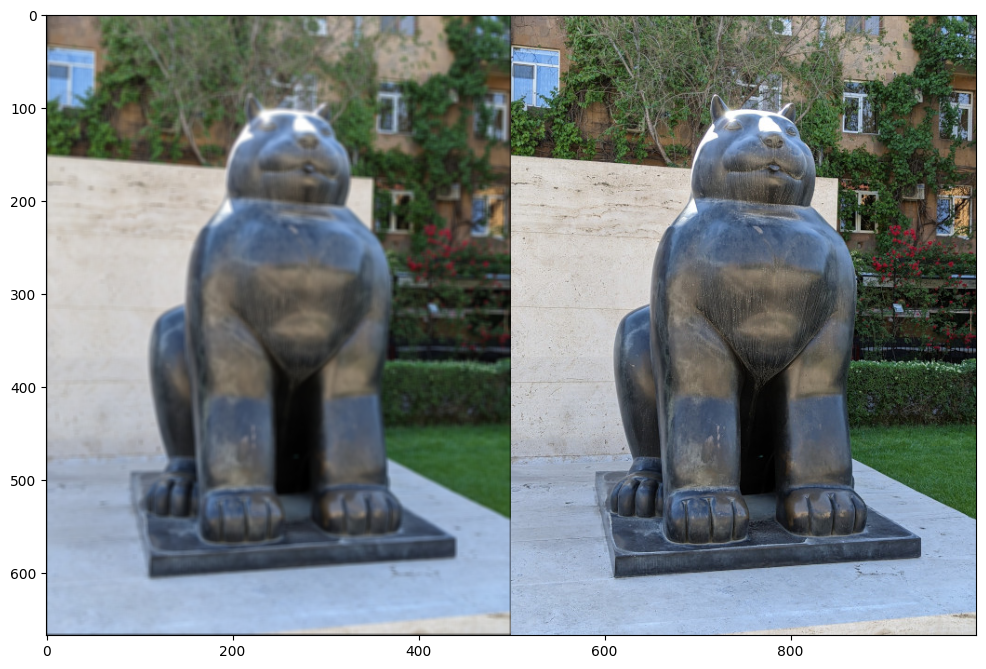

In [102]:
img_blur = color_convolution(img, kernel_blur)

plt.figure(figsize = (12,10))
plt.imshow(jnp.hstack((img_blur, img)))

In [103]:
def matrix_filter(channel, kernel):
    filtered_channel = convolve2d(channel, kernel, mode="same")
    filtered_channel = jnp.clip(filtered_channel, 0.0, 1.0)
    return filtered_channel

color_convolution_vmap = jax.vmap(matrix_filter, in_axes=(2, None), out_axes=2)

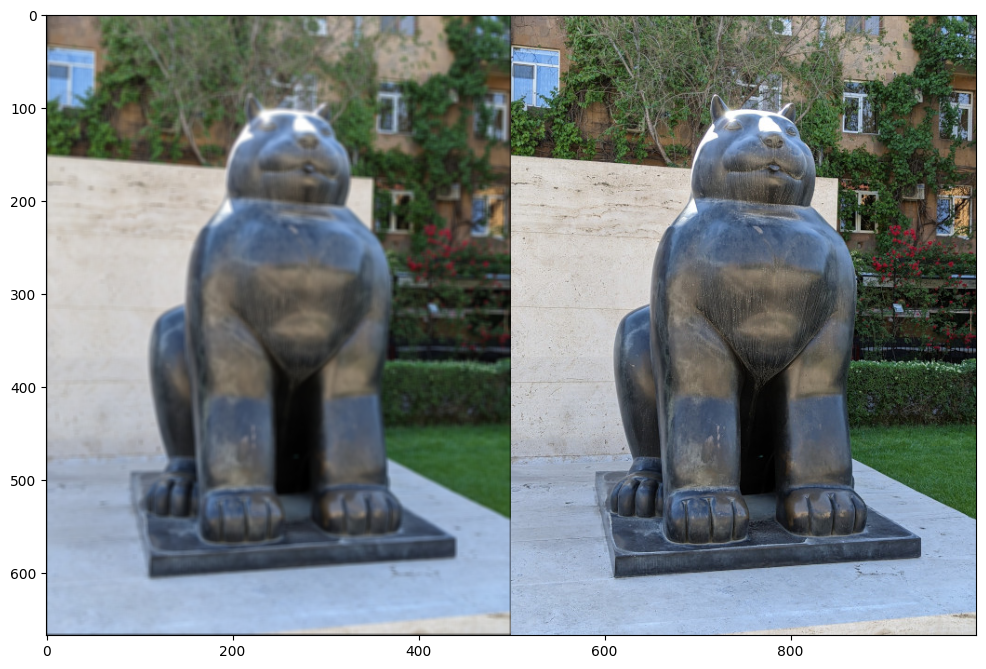

In [104]:
img_blur = color_convolution_vmap(img, kernel_blur)

plt.figure(figsize = (12,10))
plt.imshow(jnp.hstack((img_blur, img)))

In [105]:
%timeit color_convolution(img, kernel_blur).block_until_ready()

565 ms ± 135 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [106]:
%timeit color_convolution_vmap(img, kernel_blur).block_until_ready()

368 ms ± 10 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [107]:
color_convolution_jit = jax.jit(color_convolution)
color_convolution_vmap_jit = jax.jit(color_convolution_vmap)

In [108]:
color_convolution_jit(img, kernel_blur);
color_convolution_vmap_jit(img, kernel_blur);

In [109]:
%timeit color_convolution_jit(img, kernel_blur).block_until_ready()

399 ms ± 96.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [110]:
%timeit color_convolution_vmap_jit(img, kernel_blur).block_until_ready()

358 ms ± 6.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
